# Projet Encolleuse - Traitement d'images

## Introduction

Suites aux travaux sur la modélisation du cordon de colle, nous avons acquis une collection d'images que nous allons utiliser afin de comparer les résultats des calculs à la réalité de ce que produit réellement l'encolleuse.

La qualité de ces images va être d'une importance primordiale afin de pouvoir mesurer et caractériser les résultats des essais de façon répétable et fiable.

Ci-dessous, la collection d'image à traiter :

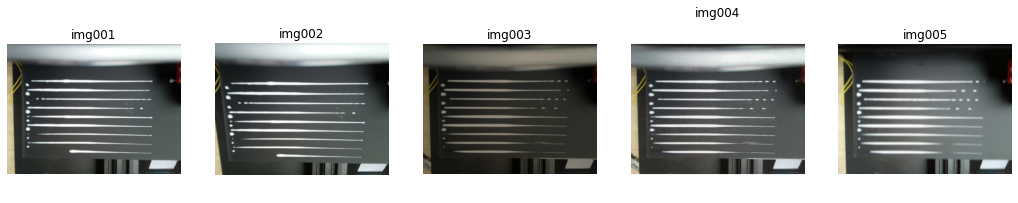

In [258]:
import matplotlib.pyplot as plt
import imageio.v2 as imageio


plt.figure(figsize=(18,12))
for i in range(5):
    ext = '.jpg'
    if i == 3 :
        ext = '.png'
    img = imageio.imread('assets/img/raw/img00'+str(i+1)+ext)
    plt.subplot(1,5,i+1)
    plt.title('img00'+str(i+1))
    plt.imshow(img)
    plt.axis('off')

Dans ce notebook Jupyter, vous allez donc retrouver :

- Différents algorithmes permettant d'améliorer la qualité des images en fonction du problème rencontré.
- Un pipeline permettant d'automatiser le traitement des images reçues en acquisition.
- Une image exploitable pour la comparaison des résultats de la modélisation au cas réel.

## Traitement des images de la collection

Chaque image de cette collection présente une caractéristique :
1. img001 : Utilisable pour les mesures
2. img002 : Les dépôts de colle sont déformés à cause d'un mouvement de caméra imprévu
3. img003 : L'image est trop sombre
4. img004 : L'image est bruitée
5. img005 : L'image est floue

Nous allons traiter chacune de ces images afin d'améliorer la qualité de celles-ci et obtenir un niveau de netteté les rendant exploitables au maximum.

### Traitement de l'image img001
Cette image est déjà exploitable pour nos mesures, néanmoins, nous allons la rendre encore plus exploitable pour les besoins de nos mesures.

Pour cela, il nous faudra garantir une netteté maximale de l'image et ensuite accentuer le paramètre à mesurer qui est le diamètre du cordon de colle.

(Le travail effectué sur cette image servira de pipeline de base pour toute image acquise, c'est-à-dire, sans filtrage en amont ou prise en compte des problèmes que l'image présente).

In [259]:
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from scipy import ndimage
import cv2

(-0.5, 909.5, 599.5, -0.5)

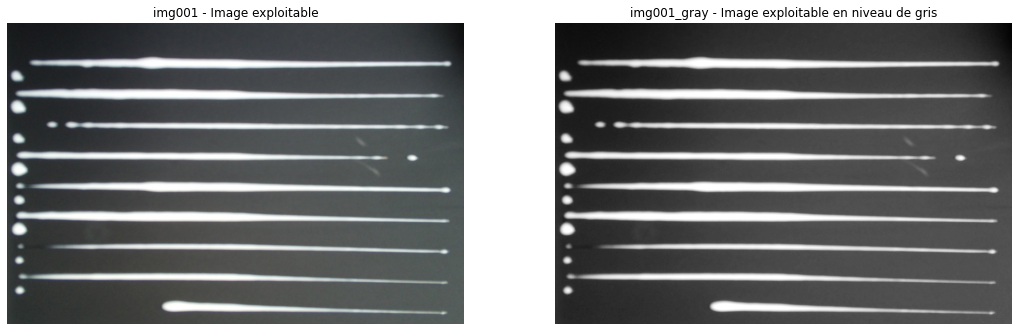

In [260]:
plt.figure(figsize=(18,12))
# Image de base
plt.subplot(1,2,1)
img001 = imageio.imread('assets/img/raw/img001.jpg')
img001 = img001[180:780, 120:1030]

plt.title('img001 - Image exploitable')
plt.imshow(img001)
plt.axis('off')

# Image en niveau de gris
plt.subplot(1,2,2)
img001_gray = imageio.imread('assets/img/raw/img001.jpg', pilmode='F')
img001_gray = img001_gray[180:780, 120:1030]

plt.title('img001_gray - Image exploitable en niveau de gris')
plt.imshow(img001_gray, cmap='gray')
plt.axis('off')

#### Filtre de lissage Gaussien
Le filtre de lissage gaussien permet de débruiter une image quelconque, éliminant ainsi les risques de parasite sous forme de bruit en utilisant du floutage.

(-0.5, 909.5, 599.5, -0.5)

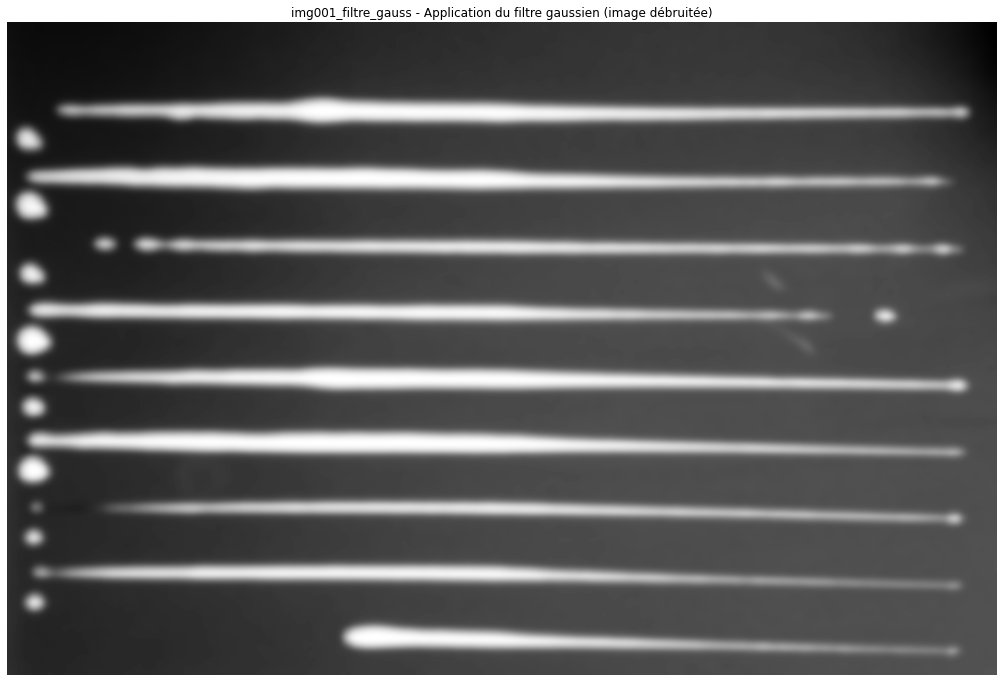

In [261]:
plt.figure(figsize=(18,12))
img001_filtre_gauss = ndimage.gaussian_filter(img001_gray, sigma=3)
plt.title('img001_filtre_gauss - Application du filtre gaussien (image débruitée)')
plt.imshow(img001_filtre_gauss, cmap='gray')
plt.axis('off')

#### Unsharp mask
Le principe du unsharp masking prend la différence entre l'image d'origine et une version artificiellement bruitée de cette image.

- On note F l'image d'origine
- On note F barre la version bruitée de l'image F
- On note Fhp l'unsharp mask relevant les contours de l'image F, Fhp = F - F barre
- On note Finale l'image accentuée, Finale = F + alpha . Fhp

In [262]:
# Soit f l'image d'origine (ici img001)
f = img001_gray

# Soit f_barre l'image débruitée
f_barre = img001_filtre_gauss

# Soit f_hp l'image de contours
f_hp = f - f_barre

# On utilise un facteur d'accentuation noté alpha généralement entre 0.3 et 0.7
alpha = 0.3
# Soit finale l'image resultant du traitement effectué
finale = f + (alpha * f_hp)

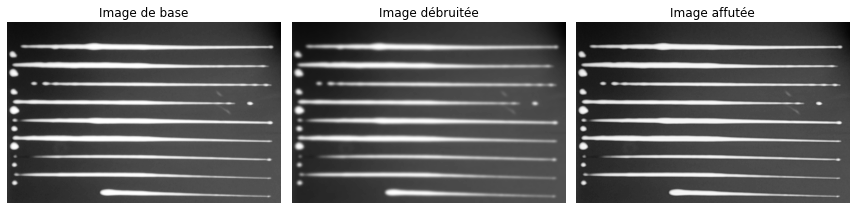

In [263]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title('Image de base')
plt.imshow(f, cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(132)
plt.title('Image débruitée')
plt.imshow(f_barre, cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(133)
plt.title('Image affutée')
plt.imshow(finale, cmap=plt.cm.gray)
plt.axis('off')
plt.tight_layout()
plt.show()

#### Conversion des pixels de l'image en binaire
Nous sommes intéressés par le diamètre des dépôts de colle, nous allons donc mettre en valeur ceux-ci en rendant les pixels de l'image exclusivement en noir et blanc.

(-0.5, 909.5, 599.5, -0.5)

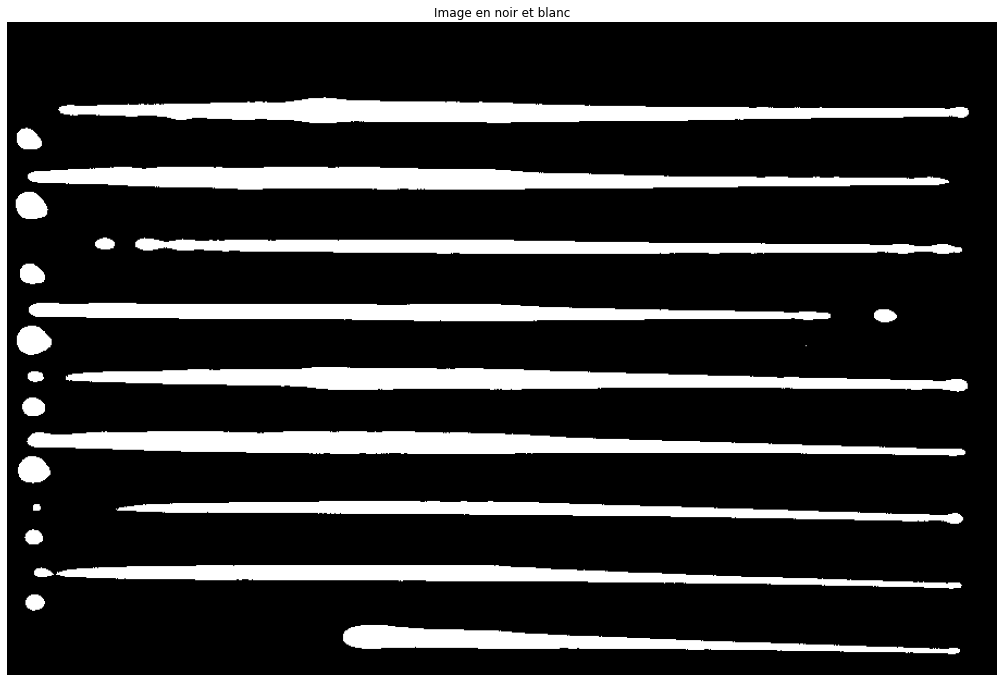

In [264]:
plt.figure(figsize=(18, 12))
_, img001_binary = cv2.threshold(finale,127, 255, cv2.THRESH_BINARY)
plt.title('Image en noir et blanc')
plt.imshow(img001_binary, cmap='gray')
plt.axis('off')

#### Mesure du diamètre des dépôts de colle

Concernant la mesure du diamètre des cordons, nous avons utilisé la fonction ```findContours``` de la librairie cv2 qui permet la detection des cordons et l'accès à certaines valeurs, tel que la position ou encore les dimensions (longueur et largeur) des cordons. Ensuite, pour l'aspect visuel, nous affichons les contours ainsi que la largeur associé via les fonctions ```putText``` et ```rectangle``` sur notre image de base.

24 pixels
21 pixels
15 pixels
17 pixels
23 pixels
23 pixels
21 pixels
22 pixels
27 pixels


(-0.5, 909.5, 599.5, -0.5)

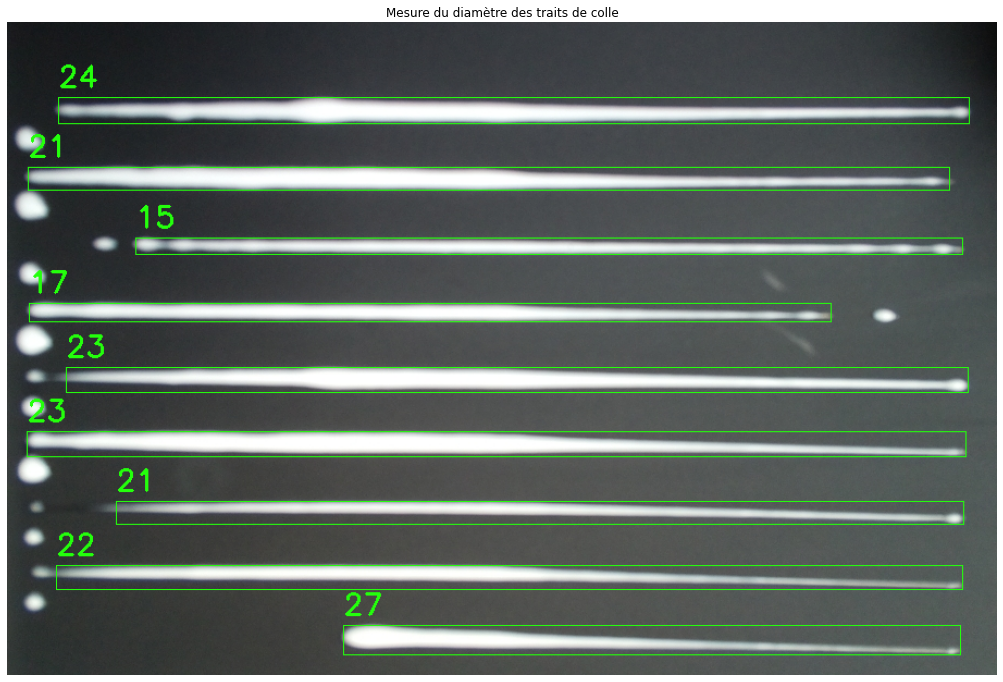

In [265]:
abs_dst = cv2.convertScaleAbs(img001_binary)
cnts = cv2.findContours(image=abs_dst, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

cnts = cnts[0] if len(cnts) == 2 else cnts[1]
lines = []
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    if(w > 50):
        cv2.putText(img001, str(h), (x,y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
        cv2.rectangle(img001, (x, y), (x + w, y + h), (36,255,12), 1)
        lines.insert(0, h)

for line in lines:
    print(str(line) + " pixels")

cv2.imwrite('assets/img/processed/measure.jpg', img001)

plt.figure(figsize=(18, 12))
plt.title('Mesure du diamètre des traits de colle')
plt.imshow(img001)
plt.axis('off')

Nous avons donc accès à un tableau de mesure (unité: pixel), ainsi qu'une image avec les mesures (unité: pixel).

N'ayant pas encore accès à de la colle pour pouvoir encoller, ni de caméra, nous avons décidé d'exploiter dans un premier temps les photos fournies de test de dépôt de colle déjà réalisé. Cette exploitation ne peut pas pour l'instant retourner de valeur en **centimètre** pour la largeur du cordon de colle car le plateau utilisé pour ces tests est différent de celui de notre prototype, et aucune échelle ne nous a été communiquée. Les résultats de l'exploitation des images seront donc la largeur du cordon de colle en **pixels**, et seront **ultérieurement** convertis en **centimètre**. Cette manipulation restante n'est qu'une conversion du nombre de pixels en centimètres, et est donc déjà représentative, bien que difficilement exploitable pour déterminer si le cordon de colle a la largeur souhaitée.
>/ ! \ Dans l'unique but de montrer que les mesures fonctionnent, nous avons decidé de ne mesurer uniquement les cordons qui ont une longueur de plus de 50 pixels. Ainsi, les petits "points" de colle ne sont pas mesuré et n'empêche pas la bonne visualisation des mesures. Dans la pipeline (situé plus bas), cette fonctionnalité de sera pas présente, car en production, nous souhaitons mesurer la largeur du cordon, peu importe sa longueur.

### Affichage des différentes étapes de traitement

In [266]:
def show_processing(images_paths:list, alpha:float):
    # Taille de la figure
    plt.figure(figsize=(18,12))


    for row in range(len(images_paths)):

        # Image d'entrée
        plt.subplot(len(images_paths),6,row*6+1)
        image = imageio.imread(images_paths[row])
        plt.title('Image de base')
        plt.imshow(image)
        plt.axis('off')

        # Image en niveau de gris
        plt.subplot(len(images_paths),6,row*6+2)
        image_gray = imageio.imread(images_paths[row], pilmode='F')
        plt.title('Niveaux de gris')
        plt.imshow(image_gray, cmap='gray')
        plt.axis('off')

        # Filtre gaussien
        plt.subplot(len(images_paths),6,row*6+3)
        filtre_gauss = ndimage.gaussian_filter(image_gray, 3)
        plt.title('Image débruitée')
        plt.imshow(filtre_gauss, cmap='gray')
        plt.axis('off')

        # Unsharp mask
        plt.subplot(len(images_paths),6,row*6+4)
        contours = image_gray - filtre_gauss
        plt.title("Contours de l'image")
        plt.imshow(contours, cmap='gray')
        plt.axis('off')

        # Image affutée
        plt.subplot(len(images_paths),6,row*6+5)
        image_nette = image_gray + alpha * contours
        plt.title('Image affutée')
        plt.imshow(image_nette, cmap='gray')
        plt.axis('off')

        # Image binaire
        plt.subplot(len(images_paths),6,row*6+6)
        _, image_binaire = cv2.threshold(image_nette,127, 255, cv2.THRESH_BINARY)
        plt.title('Image binaire')
        plt.imshow(image_binaire, cmap='gray')
        plt.axis('off')


    plt.tight_layout()
    plt.show()

Testons cette fonction :

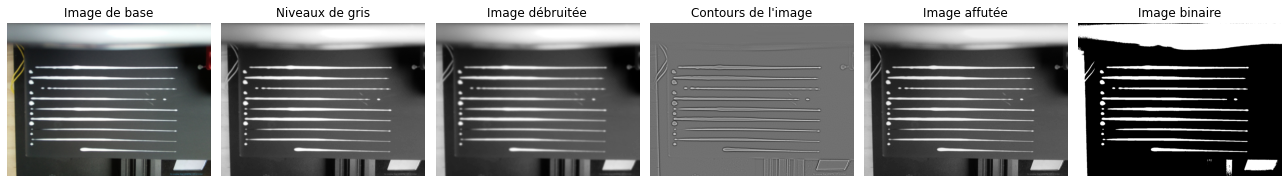

In [267]:
path1 = ['assets/img/raw/img001.jpg']
show_processing(path1, 0.3)

Testons cette fonction avec notre collection d'images :

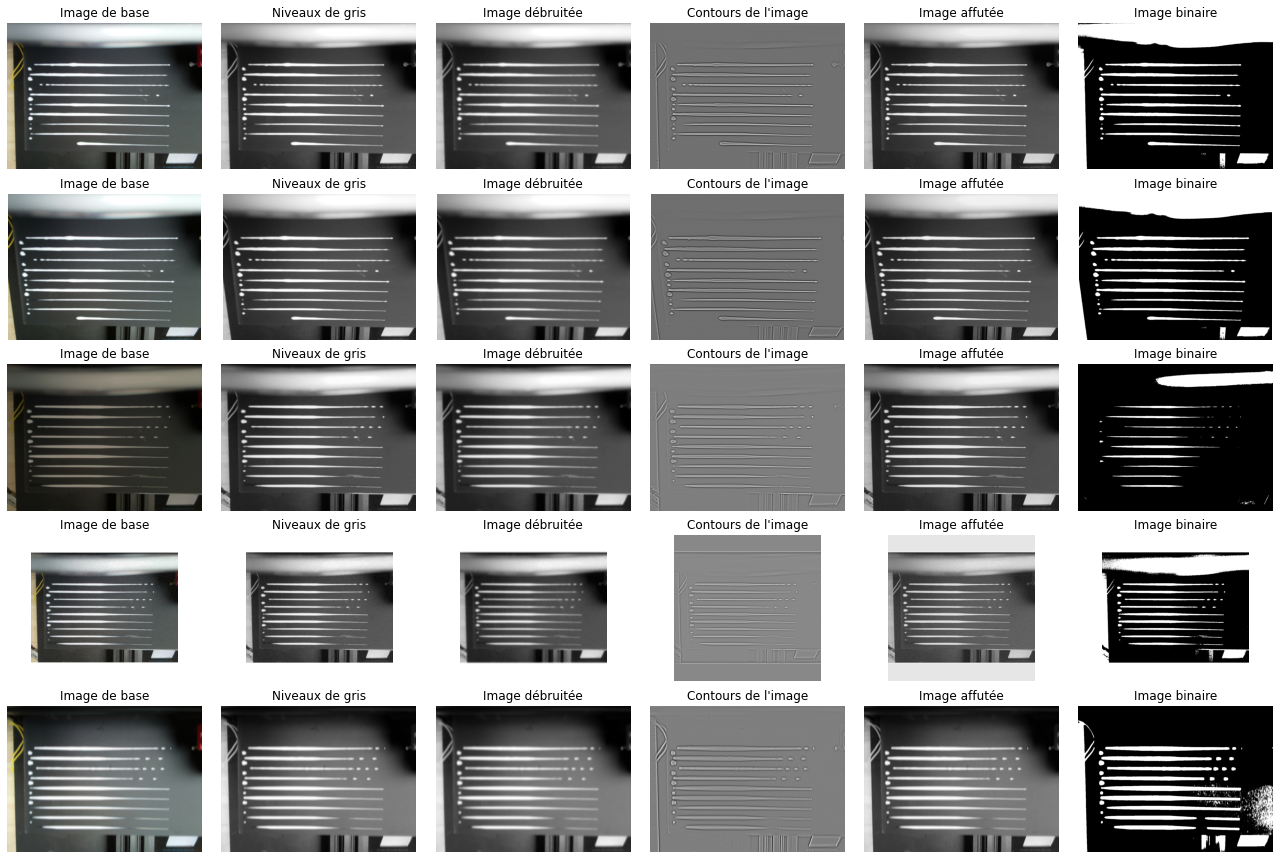

In [268]:
paths = ['assets/img/raw/img001.jpg', 'assets/img/raw/img002.jpg', 'assets/img/raw/img003.jpg', 'assets/img/raw/img004.png', 'assets/img/raw/img005.jpg']
show_processing(paths, 0.3)

### Pipeline
Voici le script complet de notre pipeline :

In [269]:
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import cv2
from scipy import ndimage


def image_processing_pipeline(path:str):
    """
    Traite l'image en entrée et renvoie les mesures du diamètre des cordons de colle.
    :param path: Chemin du fichier de l'image
    :return: (Image de base avec les mesures du diamètre des cordons de colle, Tableau des mesures de diamètre des cordons de colle)
    """

    # Image d'entrée
    img = imageio.imread(path)
    img = img[180:780, 120:1030]

    # Image en niveaux de gris
    img_gray = imageio.imread(path, pilmode='F')
    img_gray = img_gray[180:780, 120:1030]

    # Filtre gaussien
    img_gauss = ndimage.gaussian_filter(img_gray, 3)

    # Unsharp mask
    unsharp_mask = img_gray - img_gauss

    # Image affutée
    img_sharpened = img_gray + 0.3 * unsharp_mask

    # Image en noir et blanc
    _, img_binary = cv2.threshold(img_sharpened, 127, 255, cv2.THRESH_BINARY)

    # Conversion de l'image binaire en uint8
    image_scale_abs = cv2.convertScaleAbs(img_binary)

    # Détection des cordons
    contours_detection = cv2.findContours(image=image_scale_abs, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    contours_detection = contours_detection[0] if len(contours_detection) == 2 else contours_detection[1]

    # Liste des valeurs de largeur des cordons
    widths = []

    # Mesures du diamètre des cordons
    for c in contours_detection:
        x,y,w,h = cv2.boundingRect(c)
        cv2.putText(img, str(h), (x,y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
        cv2.rectangle(img, (x, y), (x + w, y + h), (36,255,12), 1)
        widths.insert(0, h)

    return img, widths

### Enregistrer les images traitées

In [270]:
def save_processed_img(processed_img, filename:str):
    return cv2.imwrite('assets/img/processed/'+filename, processed_img)

### Test du pipeline et enregistrement de l'image:

Liste des largeurs de cordon de colle en pixel : [24, 20, 21, 25, 11, 15, 19, 17, 12, 27, 1, 23, 10, 17, 23, 25, 21, 6, 14, 22, 9, 15, 27]
Image enregistrée avec succès !


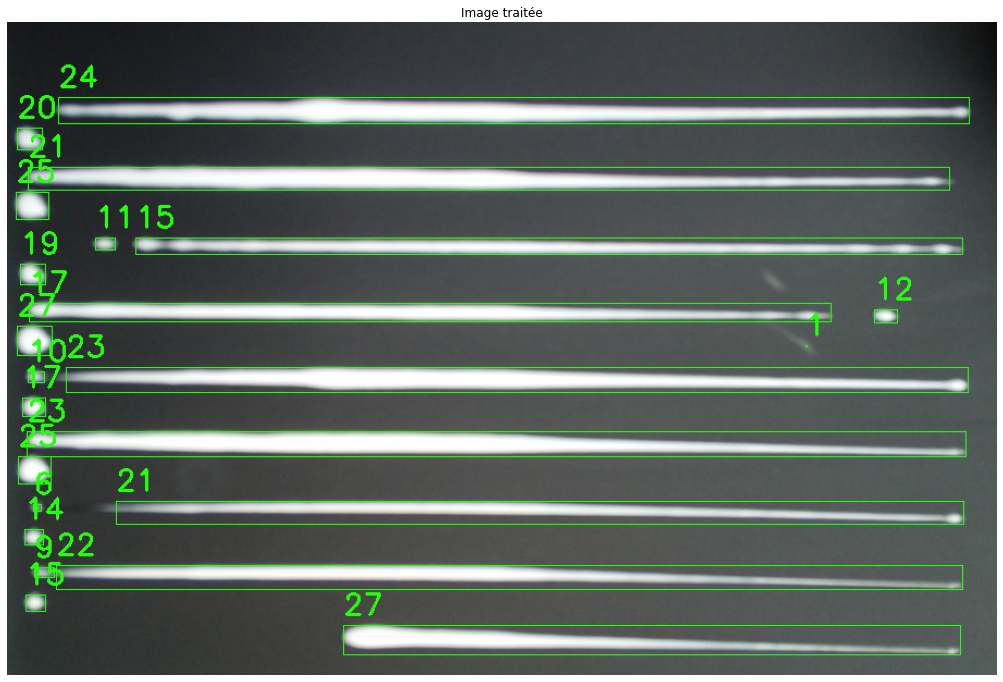

In [271]:
# Acquisition des résultats du pipeline
test_img, test_width = image_processing_pipeline('assets/img/raw/img001.jpg')

plt.figure(figsize=(18,12))
plt.imshow(test_img)
plt.title('Image traitée')
plt.axis('off')
print(f'Liste des largeurs de cordon de colle en pixel : {test_width}')

# Enregistrement de l'image
if save_processed_img(test_img, 'test001.jpg'):
    print('Image enregistrée avec succès !')